# Two-dimensional Convolution Demo

In [1]:
import itertools
import torch
import matplotlib.pyplot as plt
import math

%load_ext lab_black

PI = math.pi

torch.set_printoptions(precision=3, sci_mode=False, threshold=4000)

## Definition of convolution

Let $\phi(x)$ and $w(x)$ be real-valued scalar functions defined on $\mathbb{R}^2$ which decay to zero as $x \to \pm \infty$.
Their convolution is another function defined by the integral transform,

$$
(w \ast \phi)(x) = \int_{\mathbb{R}^2} \mathrm{d} y \, w(y) \phi(x - y) \, .
$$

We will take the view that $\phi(x)$ is the function being transformed, and $w(y)$ is the **kernel** of the transform.
The discretized version of this operation is

$$
(w \ast \phi)(n) = \sum_{m \in \mathbb{Z}^2} w(m) \phi(n - m) \, .
$$

We are interested in the situation where the domain is a square lattice $\Lambda \subset a \mathbb{N}^2$, which is periodic in both dimensions with period $aL$, where $a$ is the lattice spacing.
On this domain the convolution can be written

$$
    (w \ast \phi)(an) = \sum_{m_1, m_2=0}^{L-1} w(am) \phi\big(a(n-m)_{\text{mod} L}\big) \, .
$$

Let us set the lattice spacing to $a = 1$ so that $x \equiv n$ and $y \equiv m$.

$$
    (w \ast \phi)(x) = \sum_{y_1, y_2=0}^{L} w(y) \phi\big((x-y)_{\text{mod} L}\big) \, .
$$

In fact, the traditional conventional convolutional neural network performs a cross-correlation '$\star$' rather than a convolution '$\ast$'.
For real-valued functions this differs by nothing more than a reflection in $\phi$;

$$
    (w \star \phi)(x) = \sum_{y_1, y_2=0}^{L} w(y) \phi\big((x+y)_{\text{mod} L}\big) \, .
$$

## PyTorch implementation: `conv2d`

### Kernel shape

PyTorch implements two-dimensional cross-correlation via `torch.nn.functional.conv2d`. However, it expects the kernel to be a matrix centered on the (0, 0) element, and automatically pads this kernel with zeros to match the size of $\phi$.

For example, a nearest-neighbour kernel would look like the following
\begin{align}
w =
\begin{pmatrix}
0 & e & 0 \\
d & a & b \\
0 & c & 0
\end{pmatrix} \, ,
\end{align}

and not

\begin{align}
w = 
\begin{pmatrix}
a & b & 0 & \ldots & 0 & d \\
c & 0 & 0 & \ldots & 0 & 0 \\
0 & 0 & 0 & & & \vdots \\
\vdots & \vdots & & \ddots & & \vdots \\
0 & 0 & & & \ddots & \vdots\\
e & 0 & \ldots & \ldots & \ldots & 0
\end{pmatrix} \, ,
\end{align}

the latter being implied by the sum $\sum_{y_1, y_2=0}^L w(y)$ in the equation above.

### Input dimensions

`conv2d` also expects both $w$ and $\phi$ to have four dimensions:
1. Batch dimension
2. Channel dimension
3. Width
4. Height

### Input padding

By default, the kernel does not wrap around the lattice dimensions as we would like it to. We have to manually pad $\phi$ in order to achieve this. For example, for a $3 \times 3$ kernel we would have to pad each boundary with one extra lattice site:

\begin{align}
\begin{pmatrix}
\phi_{00} & \ldots & \phi_{0L} \\
\vdots & \ddots  & \vdots \\
\phi_{L0} & \ldots & \phi_{LL}
\end{pmatrix}
\longrightarrow
\begin{pmatrix}
\phi_{LL} & \phi_{L0} & \ldots & \phi_{LL} & \phi_{0L} \\
\phi_{0L} & \phi_{00} & \ldots & \phi_{0L} & \phi_{00} \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
\phi_{LL} & \phi_{L0} & \ldots & \phi_{LL} & \phi_{L0} \\
\phi_{0L} & \phi_{00} & \ldots & \phi_{0L} & \phi_{00}
\end{pmatrix}
\end{align}


In [2]:
def conv2d_inputs(phi, w):
    """Reshape and pad inputs for conv2d.

    conv2d expects shapes:

    - input (phi) : (batch size, input channels, width, height)
    - kernel (w)  : (batch size, output channels, kernel width, kernel height)

    However, our input is periodic so we also need to pad phi by an amount
    K, which is the kernel radius.
    """
    assert phi.dim() in (2, 3)
    assert w.dim() == 2

    if phi.dim() == 2:
        phi = phi.unsqueeze(0)  # add batch dim
    phi = phi.unsqueeze(1)  # add channel dim

    k1, k2 = [(k - 1) // 2 for k in w.shape]
    w = w.view(1, 1, *w.shape)
    phi = torch.nn.functional.pad(
        phi,  # (n_batch, n_channels, width, height)
        pad=(k2, k2, k1, k1),  # pad last 2 dimensions by kernel radius on each side
        mode="circular",
    )
    return phi, w

### Example: Identity transformation

\begin{align}
w_{id} =
\begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0
\end{pmatrix}
\end{align}

In [3]:
L = 6
phi = torch.empty(L, L).normal_()
w = torch.Tensor(
    [
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
    ]
)
conv_out = torch.nn.functional.conv2d(*conv2d_inputs(phi, w))
assert torch.allclose(conv_out, phi)

### Example: Shift one lattice unit to the left

\begin{align}
w_{\leftarrow} =
\begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0
\end{pmatrix}
\end{align}

In [4]:
L = 4
phi = torch.arange(L * L).reshape(L, L).float()
w = torch.Tensor(
    [
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
    ]
)
conv_out = torch.nn.functional.conv2d(*conv2d_inputs(phi, w))

# Check the direction of torch.roll
assert phi.roll(shifts=(-1, -1), dims=(0, 1))[0, 0] == phi[1, 1]

assert torch.allclose(conv_out, phi.roll(-1, dims=1))

## `conv2d` implements cross-correlation

We can check that conv2d implements cross-correlation, defined by

\begin{align}
    (w \star \phi)(x) = \sum_{y_1, y_2=0}^{L} w(y) \phi\big((x+y)_{\text{mod} L}\big) \, .
\end{align}

This requires us to modify the kernel so that it looks like a full $L \times L$ matrix with the `(0, 0)` element in the top-left corner.
    
For example, conv2d interprets the following tensor as having `b` in the `(0, 0)` position, `a` in the `(L, L)` position and `c` in the `(1, 1)` position:
    
```python
torch.Tensor([
    [a, 0, 0],
    [0, b, 0],
    [0, 0, c]
])
```
However, to match our cross-correlation calculation we require an L1 x L2 tensor that looks like the following:
    
```python
torch.Tensor([
    [b, 0, ..., 0],
    [0, c, ..., 0],
         ...
    [0, 0, ..., a]
])
```
    
Therefore, we need to:
1. Pad the tensor with zeros to make it the same shape as the input
2. Roll the kernel so that the (0, 0) element is in the top-left corner

In [5]:
def pad_and_roll_kernel(phi, w):
    """Pad and roll kernel so that we can compute the cross-correlation."""
    L1, L2 = phi.shape[-2:]
    k1, k2 = [(k - 1) // 2 for k in w.shape]

    # Pad with zeros to make it the same size as phi
    w = torch.nn.functional.pad(
        w, (0, L2 - w.shape[1], 0, L1 - w.shape[0]), mode="constant", value=0
    )

    # Roll the kernel
    w = w.roll((-k1, -k2), (0, 1))

    return w


# ------------------------------------ #
# TEST 1: expansion of diagonal kernel #
# ------------------------------------ #
L = 6
phi = torch.empty(L, L).normal_()
w = torch.Tensor(
    [
        [1, 0, 0],
        [0, 2, 0],
        [0, 0, 3],
    ]
).int()
expected = torch.Tensor(
    [
        [2, 0, 0, 0, 0, 0],
        [0, 3, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
    ]
).int()
result = pad_and_roll_kernel(phi, w)
assert torch.equal(result, expected)


# ----------------------------------- #
# TEST 2: conv2d is cross correlation #
# ----------------------------------- #
w = torch.empty(L - 1, L - 1).uniform_()
conv_out = torch.nn.functional.conv2d(*conv2d_inputs(phi, w))

w = pad_and_roll_kernel(phi, w)
cross_corr = torch.stack(
    [
        w[y1, y2] * phi.roll((-y1, -y2), (0, 1))
        for y1, y2 in itertools.product(range(L), range(L))
    ],
    dim=0,
).sum(dim=0)
assert torch.allclose(cross_corr, conv_out)


# ------------------------------------------------- #
# TEST 3: explicit calculation of cross correlation #
# ------------------------------------------------- #
cross_corr_explicit = torch.zeros_like(phi)
for x1 in range(L):
    for x2 in range(L):
        for y1 in range(L):
            for y2 in range(L):
                res = w[y1, y2] * phi[(x1 + y1) % L, (x2 + y2) % L]
                cross_corr_explicit[x1, x2] += res
assert torch.allclose(cross_corr_explicit, conv_out)

## Cross-correlation as a matrix-vector product

Discrete cross correlation (or convolution) can be expressed as a matrix-vector product

\begin{align}
w \star \phi \equiv W . \Phi
\end{align}

For example, consider this cross correlation:

\begin{align}
w \star \phi = 
\begin{pmatrix}
0 & 1 & 0 \\
1 & 1 & 1 \\
0 & 1 & 0
\end{pmatrix}
\star
\begin{pmatrix}
\phi_{00} & \phi_{01} & \phi_{02} & \phi_{03} \\
\phi_{10} & \phi_{11} & \phi_{12} & \phi_{13} \\
\phi_{20} & \phi_{21} & \phi_{22} & \phi_{23} \\
\phi_{30} & \phi_{31} & \phi_{32} & \phi_{33}
\end{pmatrix}
\end{align}

Each element of $(w \star \phi)(x)$ can be seen as a dot-product between the vectorised kernel and configuration, after padding the kernel with zeros to match the size of $\phi$ and rolling it so that the kernel is centred on $x$.

For example, for the $(0, 0)$ element we first expand the kernel to match the size of $\phi$ and roll it so that the (0, 0) element is in the top-left corner:

\begin{align}
\begin{pmatrix}
0 & 1 & 0 \\
1 & 1 & 1 \\
0 & 1 & 0
\end{pmatrix} \longrightarrow
\begin{pmatrix}
1 & 1 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
1 & 0 & 0 & 1
\end{pmatrix}
\end{align}

and then flatten both kernel and input state

\begin{align}
(w \star \phi)(0, 0) = \begin{pmatrix}
1 & 1 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1
\end{pmatrix}
\cdot
\begin{pmatrix}
\phi_{00} \\ \phi_{01} \\ \phi_{02} \\ \phi_{03} \\
\phi_{10} \\ \phi_{11} \\ \phi_{12} \\ \phi_{13} \\
\phi_{20} \\ \phi_{21} \\ \phi_{22} \\ \phi_{23} \\
\phi_{30} \\ \phi_{31} \\ \phi_{32} \\ \phi_{33}
\end{pmatrix}
\end{align}

For the $(1, 1)$ element we would start from

\begin{align}
\begin{pmatrix}
0 & 1 & 0 \\
1 & 1 & 1 \\
0 & 1 & 0
\end{pmatrix} \longrightarrow
\begin{pmatrix}
0 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix} \longrightarrow
\begin{pmatrix}
0 & 1 & 0 & 0 & 1 & 1 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0
\end{pmatrix}
\end{align}

and so on, until we have a $16 \times 16$ matrix acting on the vector $\Phi$.

**Note:** The usefulness of this form is that we can (naively) compute the Jacobian of $W$ and hence the change in density due to the transformation.

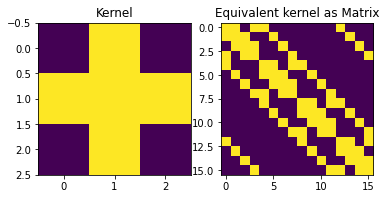

In [6]:
def to_matrix_vector(w, phi):
    """Convert a kernel and 2d state to an equivalent matrix-vector form.

        w * \phi  == W . Phi

    Inputs
    ------
    w: 2-dimensional kernel
    phi: 2-dimensional state, with optional batch dimension

    Returns
    -------
    W: square matrix whose dimensions are equal to the size of a 2-d state
    Phi: vectorised state, i.e. with lattice dimensions flattened
    """
    assert phi.dim() in (2, 3)
    if phi.dim() == 2:
        phi = phi.unsqueeze(0)

    # (0, 0) element is in top left
    w = pad_and_roll_kernel(phi, w)
    assert w.dim() == 2

    W = torch.stack(
        [
            w.roll((x1, x2), dims=(0, 1)).flatten()
            for x1, x2 in itertools.product(range(w.shape[0]), range(w.shape[1]))
        ],
        dim=0,
    )
    Phi = phi.flatten(start_dim=1)

    return W, Phi


# ----------------------- #
# TEST 1: Identity kernel #
# ----------------------- #
L = 4
phi = torch.arange(L * L).view(L, L)
w = torch.Tensor(
    [
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
    ]
).int()
W, Phi = to_matrix_vector(w, phi)
assert torch.equal(W, torch.diag(torch.ones(Phi.shape[1]).int()))


# ----------------------------- #
# TEST 2: Agreement with conv2d #
# ----------------------------- #
phi = torch.empty(L, L).normal_()
w = torch.empty(L - 1, L - 1).uniform_()
conv_out = torch.nn.functional.conv2d(*conv2d_inputs(phi, w))
W, Phi = to_matrix_vector(w, phi)
mv_out = torch.mv(W, Phi.squeeze())
assert torch.allclose(conv_out, mv_out.view(L, L))


# --------------------- #
# PLOT: Compare w and W #
# --------------------- #
w = torch.Tensor(
    [
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0],
    ]
).int()
W, Phi = to_matrix_vector(w, phi)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Kernel")
ax1.imshow(w)
ax2.set_title("Equivalent kernel as Matrix")
ax2.imshow(W)

## Block-circulant matrix representation

A **Toeplitz matrix** is a matrix with constant diagonals. The determinant of a Toeplitz matrix can be computed in $O(n^2)$ time using [Levinson recursion](https://en.wikipedia.org/wiki/Levinson_recursion).

A **circulant matrix** is a special case of Toeplitz matrix where the diagonals 'wrap around' such that each row is equal to the row above, shifted one to the right. Circulant matrices are diagonalised by the DFT, which can be computed in $O(n\log n)$ time using the FFT algorithm. The determinant can hence be computed in $O(n\log n)$.

Circulant matrices arise as kernels of one-dimensional convolution or cross-correlation acting upon the cyclic group $C_n$. Hence, one-dimensional cross-correlation applied to a one-dimensional lattice field theory would take the form

\begin{align}
W_c^{1d} = \begin{pmatrix}
w_0 & w_1 &  \ldots & w_L \\
w_L & w_0 & \ldots & w_{L-1}  \\
\vdots &  & \ddots & \vdots \\
w_1 & w_2 & \ldots & w_0
\end{pmatrix}
\end{align}

In our case, we are interested two-dimensional cross-correlation acting on $C_n \times C_n$ where $n = L$ the number of lattice sites in each dimension. This slightly changes things; in the matrix-vector form described above the matrix $W$ is not circulant, but **block circulant**.

I doubt this will come in useful, but maybe if I had a 2d convolution kernel as the outputs of a coupling layer where the partitioning was over vector dimensions of the field, I might want to optimise the determinant computation... Anyway, see [this reference](https://mro.massey.ac.nz/bitstream/handle/10179/4456/Eigenvectors_of_block_circulant_and_alternating_circulant_matrices.pdf;sequence=1) if it becomes interesting.

# Rubbish bin

Example: Free Theory

Now consider the kernel

$$
w = 
\begin{pmatrix}
a & b & c\\
b & d & e \\
c & e & f
\end{pmatrix}
$$

acting on a $4 \times 4$ diagonal Gaussian

$$
\phi = 
\begin{pmatrix}
\phi_{00} & \phi_{01} & \phi_{02} & \phi_{03} \\
\phi_{10} & \phi_{11} & \phi_{12} & \phi_{13} \\
\phi_{20} & \phi_{21} & \phi_{22} & \phi_{23} \\
\phi_{30} & \phi_{31} & \phi_{32} & \phi_{33}
\end{pmatrix}
$$

For example,

$$
(w \star \phi)_{00} = a \phi_{33} + b(\phi_{03} + \phi_{30}) + c(\phi_{13} + \phi_{31}) + d\phi_{00} + e(\phi_{01} + \phi_{10}) + f\phi_{11}
$$

The diagonal elements of the covariance matrix are

$$
\langle (w \star \phi)_{ii} (w \star \phi)_{ii} \rangle 
= a^2 + 4b^2 + 4c^2 + d^2 + 4e^2 + f^2
$$

$$
\begin{aligned}
\langle (w \star \phi)_{00} (w \star \phi)_{01} \rangle 
&= \left\langle 
\left( a \phi_{33} + b(\phi_{03} + \phi_{30}) + c(\phi_{13} + \phi_{31}) + d\phi_{00} + e(\phi_{01} + \phi_{10}) + f\phi_{11} \right)
\left( a \phi_{30} + b(\phi_{31} + \phi_{00}) + c(\phi_{32} + \phi_{10}) + d\phi_{01} + e(\phi_{02} + \phi_{11}) + f\phi_{12} \right) 
\right\rangle \\
&= ab \langle\phi_{30}^2\rangle + cb \langle\phi_{31}^2\rangle + db\langle\phi_{00}^2\rangle + ed\langle\phi_{01}^2\rangle + ec\langle\phi_{10}\rangle + fe\langle\phi_{11}^2\rangle \\
&= ab + cb + db + ed + fe
\end{aligned}
$$

First, expand the kernel to match the size of $\phi$ and roll it so that the (0, 0) element is in the top-left corner:
\begin{align}
\begin{pmatrix}
0 & 1 & 0 \\
1 & 1 & 1 \\
0 & 1 & 0
\end{pmatrix} \longrightarrow
\begin{pmatrix}
1 & 1 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
1 & 0 & 0 & 1
\end{pmatrix}
\end{align}


Usually we want a convolutional layer to encode some local structure in the data.
This leads to kernels that are nonzero only within some radius $K$ of $y=(0, 0)$.
For example, on a square lattice, a kernel with radius $K=1$ is represented by the following matrix

\begin{align}
w(y) = \begin{pmatrix}
\ddots \\
& 0 & 0 & 0 & 0 & 0 \\
& 0 & 0 & w(L, 0) & 0 & 0 \\
& 0 & w(0, L) & w(0, 0) & w(0, 1) & 0 \\
& 0 & 0 & w(1, 0) & 0 & 0 \\
& 0 & 0 & 0 & 0 & 0 & \\
&&&&&&\ddots
\end{pmatrix}
\end{align}

Discrete convolution or cross correlation can be expressed as a matrix-vector product

$$
w \star \phi \equiv W . \Phi
$$

where the vector $\Phi$ is the flattened $\phi$ and the matrix $W$ is a representation of $w$ as a **Toeplitz matrix** (a matrix with constant diagonals).
For brevity, let $w(y_1, y_2)$ be written $w_{y_1y_2}$.
The $K=1$ kernel described above now becomes

\begin{align}
    W = \begin{pmatrix}
    w_{00} & w_{01} & 0 & \ldots & 0 & w_{0L} & w_{10} & 0 & \ldots & 0 & w_{LL} \\
    w_{LL} & w_{00} & w_{01} & 0 & \ldots & 0 & w_{0L} & w_{10} &  0 & \ldots & 0\\
    0 & w_{LL} & w_{00} & w_{01} & 0 & \ldots & 0 & w_{0L} & w_{10} & 0 & \ldots \\
    & & & & & \ddots\\
    w_{01} & 0 & \ldots & 0 & w_{0L} & w_{10} & 0 & \ldots & 0 & w_{LL} & w_{00}
    \end{pmatrix}
\end{align}